In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Checking stocks

In [2]:
#stocks = ['CHMF','NLMK','GMKN','AKRN','VSMO','MAGN','TATNP','SNGSP','MTSS','SIBN','SBER','LKOH']
stocks_all = ['NLMK','RASP','SBERP','SIBN','SNGSP','SVAV','VSMO','AFLT','GAZP','SBER','ROSN','SNGS','LKOH','RTKM','TATN','TATNP','MTSS','AKRN','CHMF','GMKN','MAGN','MGNT']

In [3]:
def random_stocks():
    stocks = []
    len_stocks_all = len(stocks_all)
    while True:
        i = np.random.randint(len_stocks_all)
        if len(stocks)==12:break
        if stocks_all[i] in set(stocks):continue
        stocks.append(stocks_all[i])
    return stocks    

In [4]:
in_lot = pd.read_excel('stock_in_lot.xlsx')
in_lot[in_lot.stock=='AFLT'].stock_in_lot.values

array([100], dtype=int64)

In [5]:
divs = pd.read_excel('Dividends.xlsx',parse_dates=['date'])
divs = pd.merge(divs, in_lot, left_on = 'tiker', right_on = 'stock').drop('stock',axis=1)
divs['div_by_lot'] = divs.dividend*divs.stock_in_lot

In [6]:
divs['month'] = divs['date'].apply(lambda x : x.month)
divs['year'] = divs['date'].apply(lambda x : x.year)
divs['month_id']=divs['year']*100+divs['month']

Download Data

In [7]:
prices = pd.DataFrame()
for paper in stocks_all:
    a = pd.read_csv(str(paper)+str('_070601_180903.csv'), parse_dates=[0])
    a['paper'] = paper
    a.columns = ['date', 'time', 'open', 'high', 'low', 'close','vol', 'paper']
    a.drop(['time', 'open', 'high', 'low','vol'],axis=1,inplace=True)
    a.close=a.close*in_lot[in_lot.stock==paper].stock_in_lot.values
    prices = prices.append(a)
#prices.columns = ['date', 'time', 'open', 'high', 'low', 'close','vol', 'paper']

In [8]:
def rand_date(array):
    len_ar = len(array)
    position = np.random.randint(len_ar)
    return array[position]

In [9]:
prices['month'] = prices['date'].apply(lambda x : x.month)
prices['year'] = prices['date'].apply(lambda x : x.year)
prices['month_id']=prices['year']*100+prices['month']
#prices = prices[prices.year>=2008]
months = np.unique(np.sort(prices['month_id']))

In [10]:
name = 'Ольга'

In [11]:
divs.head()

,tiker,date,dividend,stock_in_lot,div_by_lot,month,year,month_id
0,AFLT,2003-03-07,0.29,100,29.0,3,2003,200303
1,AFLT,2004-04-19,0.43,100,43.0,4,2004,200404
2,AFLT,2005-04-30,0.70,100,70.0,4,2005,200504
3,AFLT,2006-04-29,0.82,100,82.0,4,2006,200604
4,AFLT,2007-05-07,1.29,100,129.0,5,2007,200705


In [12]:
prices.head()

,date,close,paper,month,year,month_id
0,2007-06-01,715.0,NLMK,6,2007,200706
1,2007-06-04,703.8,NLMK,6,2007,200706
2,2007-06-05,715.0,NLMK,6,2007,200706
3,2007-06-06,706.0,NLMK,6,2007,200706
4,2007-06-07,699.9,NLMK,6,2007,200706


In [13]:
for cikle in range(5):
    try:
        print ('cikle = ',cikle)
        df_for_save = []
        for index in range(1):
            stocks = random_stocks()
            # start balance, just for first time
            last_balance = 1000.0

            # start current money
            cur_money = 300000.0

            # save history
            save_history = []

            # massiv for saving our investments and deals
            total_investments = []
            total_investments.append(cur_money)
            sdelki = []
            divs_year= []

            # part of portfolio for one stock
            dolya = 1.0/len(stocks)

            # create DF for saving information
            a =np.vstack([stocks,[0]*len(stocks)])
            portfolio = pd.DataFrame(a,columns=stocks).drop(0)
            aktiv = pd.DataFrame(a,columns=stocks).drop(0)

            # minimal sum for add every month
            min_add_sum = 2000.0+np.random.randint(4000)

            ##last_portfolio_bal = np.sum(aktiv)

            ## comissions by MOEX and broker
            comis = 0.001
            depo_comis = 150



            for idx, month in enumerate(months):
                ## every month add money, growing function becose we have inflation
                add_money = min_add_sum#*(1+idx/50.0)
                ## current money on account
                cur_money+=add_money
                ## saving sum of our investments 
                total_investments.append(add_money)

                ## take random day n month for investments - for exmaple
                day = rand_date(prices[prices['month_id']==month].date.values)

                ## take all preces our stocks in that day
                price = prices[prices.date==day][['close','paper']]

                ## check button 
                check=1 

                # minus month comission for payment to depositary
                cur_money-=depo_comis 

                while check!=0:
                    for idz,stock in enumerate(stocks):
                        wow_price = price[price.paper==stock].close.values
                        if int(aktiv[stock].sum())*wow_price<dolya*(last_balance+cur_money):
                            if cur_money - np.float(price[price['paper']==stock].close)*(1+comis)>0:

                                cur_money = cur_money - np.float(price[price['paper']==stock].close)*(1+comis)
                                #print ('after buy',paper,cur_money)
                                sdelki.append([stock,1,day])
                            else: 
                                sdelki.append([stock,0,day])
                                check=0        
                    sdelki1 = pd.DataFrame(sdelki)
                    aktiv = pd.pivot_table(sdelki1, index=[2], columns=[0],aggfunc=sum,)
                    aktiv = aktiv.fillna(0)
                    aktiv.columns = aktiv.columns.levels[1]

                    last_balance = cur_money
                    for i in stocks:
                        try: last_balance +=aktiv[i].sum()*price[price.paper==i].close.values
                        except ValueError:
                            continue

                divs_now = divs[divs.month_id==month]

                dividends = 0
                for paper in aktiv.columns:
                    dividend = 0
                    if divs_now[divs_now.tiker==paper].div_by_lot.size>0:
                        dividend = aktiv[paper].sum()*divs_now[divs_now.tiker==paper].div_by_lot.values
                        divs_year.append([month,float(dividend)*0.87,paper])
                    dividends += dividend

                cur_money +=float(dividends)*0.87
                #print (month, add_money,np.sum(total_investments),last_balance,dolya*last_balance,cur_money)
                #if dividends>0: print (month,'In this month your dividend is ',dividends*0.87)

                save_history.append([month,np.sum(total_investments),last_balance])
            divs_year = pd.DataFrame(divs_year, columns=['month','money','paper'])
            print ('row',index,'. Score:',(last_balance+cur_money)/np.sum(total_investments),add_money,np.sum(total_investments),last_balance+cur_money)
            save_history = pd.DataFrame(save_history, columns = ['month','sum_investments','portfolio'])
            df_for_save.append(np.hstack([add_money,np.sum(total_investments),last_balance+cur_money,(last_balance+cur_money)/np.sum(total_investments),divs_year.money.sum(),stocks]))
#             plt.figure(figsize=(12,7))
#             dates = pd.date_range(start='30/06/2007', periods=len(months), freq='M')
#             plt.plot(dates, save_history.sum_investments)
#             plt.plot(dates, save_history.portfolio)
#             plt.title(stocks)
#             plt.grid()
#             plt.legend()
#             plt.show()
        df = pd.DataFrame(df_for_save)
        sample=pd.read_excel('sample2012.xlsx',header=0)
        sample = sample.append(df)
        sample.to_excel('sample2012.xlsx')
    except: 
        df = pd.DataFrame(df_for_save)
        sample=pd.read_excel('sample2012.xlsx',header=0)
        sample = sample.append(df)
        sample.to_excel('sample2012.xlsx')
        continue

cikle =  0


C:\Users\1INVESTOR\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


row 0 . Score: [3.49739264] 5660.0 1069760.0 [3741370.74592]
cikle =  1
row 0 . Score: [3.28632322] 2872.0 690592.0 [2269508.5221]
cikle =  2
row 0 . Score: [2.9584494] 3844.0 822784.0 [2434164.82814]
cikle =  3
row 0 . Score: [2.42200168] 2175.0 595800.0 [1443028.6011]
cikle =  4
row 0 . Score: [3.07648051] 2402.0 626672.0 [1927944.19206]


In [14]:
divs_year = pd.DataFrame(divs_year, columns=['month','money','paper'])
divs_year['year'] = divs_year['month'].apply(lambda x : int(x/100.0))
divs_year_total = pd.DataFrame(divs_year.groupby(['year'])['money'].sum())
divs_year_total

,money
year,
2007,1426.6260
2008,6880.9170
2009,3125.2488
2010,4908.5922
2011,8562.4182
2012,14169.8379
2013,14103.4743
2014,38299.8969
2015,56849.2452


In [15]:
divs_paper_total = pd.DataFrame(divs_year.groupby(['paper'])['money'].sum())
divs_paper_total

,money
paper,
AFLT,58350.8130
CHMF,61305.6810
GAZP,27200.5500
LKOH,13810.3800
MAGN,43091.0130
MGNT,37312.8297
NLMK,32642.9220
ROSN,9921.3060
SNGS,6011.7000


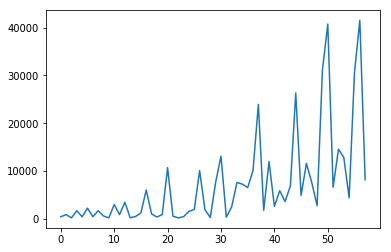

In [16]:
plt.plot(divs_year.groupby('month')['money'].sum().values)

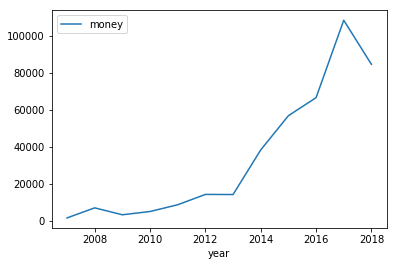

In [17]:
divs_year_total.plot()

In [18]:
aktiv.sum()

0
AFLT      20.0
CHMF      19.0
GAZP      90.0
LKOH      20.0
MAGN      59.0
MGNT      35.0
NLMK     101.0
ROSN      28.0
SNGS      22.0
SNGSP     40.0
SVAV      31.0
VSMO      10.0
dtype: float64

In [19]:
sdelki = pd.DataFrame(sdelki)

In [20]:
aktiv = pd.pivot_table(sdelki, index=[2], columns=[0],aggfunc=np.sum)
aktiv = aktiv.fillna(0)
aktiv.columns = aktiv.columns.levels[1]

In [21]:
print ('Total investments')
np.sum(total_investments)

Total investments


626672.0

In [22]:
print ('Now portfolio wheight')
last_balance = 0
for i in stocks:
    last_balance +=aktiv[i].sum()*price[price.paper==i].close.values
    print (i,aktiv[i].sum()*price[price.paper==i].close.values)
print (last_balance+cur_money)

Now portfolio wheight
AFLT [228600.]
SVAV [146320.]
MGNT [141785.]
MAGN [287271.]
GAZP [134316.]
CHMF [208316.]
NLMK [170306.2]
SNGSP [152720.]
VSMO [169300.]
ROSN [122892.]
SNGS [63184.]
LKOH [94310.]
[1927712.93103]


In [23]:
aktiv.tail()

,AFLT,CHMF,GAZP,LKOH,MAGN,MGNT,NLMK,ROSN,SNGS,SNGSP,SVAV,VSMO
2,,,,,,,,,,,,
2018-05-11,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2018-07-03,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0
2018-08-16,0.0,0.0,2.0,1.0,0.0,2.0,1.0,2.0,2.0,2.0,1.0,0.0
2018-09-03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
price

,close,paper
2817,1686.2,NLMK
2817,995.1,RASP
2816,1580.3,SBERP
2818,3386.0,SIBN
2818,3818.0,SNGSP
2815,4720.0,SVAV
2817,16930.0,VSMO
2818,11430.0,AFLT
2818,1492.4,GAZP
2816,1815.5,SBER
